# Colab Setup  
> Make sure you configure notebook with GPU: Click Edit->notebook settings->hardware accelerator->GPU

> Uncomment the following cell after opening in Google colab. (Do not uncomment it in local setup.)  

<a target="_blank" href="https://colab.research.google.com/github/SEED-VT/FedDebug/blob/main/fault-localization/artifact.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



In [1]:
# !pip install pytorch-lightning
# !pip install diskcache
# !pip install dotmap
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !git clone https://github.com/SEED-VT/FedDebug.git
# # appending the path
# import sys
# sys.path.append("FedDebug/fault-localization/")

# Running Code

In [3]:
import logging
import matplotlib.pyplot as plt
import time
from dotmap import DotMap
from pytorch_lightning import seed_everything
from torch.nn.init import kaiming_uniform_ 
from utils.faulty_client_localization.FaultyClientLocalization import FaultyClientLocalization
from utils.faulty_client_localization.InferenceGuidedInputs import InferenceGuidedInputs
from utils.FLSimulation import trainFLMain
from utils.fl_datasets import initializeTrainAndValidationDataset
from utils.util import aggToUpdateGlobalModel
from utils.util import testAccModel



logging.basicConfig(filename='example.log', level=logging.ERROR)
logger = logging.getLogger("pytorch_lightning")
seed_everything(786)



def evaluateFaultLocalization(predicted_faulty_clients_on_each_input, true_faulty_clients):
    true_faulty_clients = set(true_faulty_clients)
    detection_acc = 0
    for pred_faulty_clients in predicted_faulty_clients_on_each_input:
        print(f"+++ Faulty Clients {pred_faulty_clients}")
        correct_localize_faults = len(
            true_faulty_clients.intersection(pred_faulty_clients))
        acc = (correct_localize_faults/len(true_faulty_clients))*100
        detection_acc += acc
    fault_localization_acc = detection_acc / \
        len(predicted_faulty_clients_on_each_input)
    return fault_localization_acc


def runFaultyClientLocalization(client2models, exp2info, num_bugs, random_generator=kaiming_uniform_, apply_transform=True, k_gen_inputs=10, na_threshold=0.003, use_gpu=True):
    print(">  Running FaultyClientLocalization ..")
    input_shape = list(exp2info['data_config']['single_input_shape'])
    generate_inputs = InferenceGuidedInputs(client2models, input_shape, randomGenerator=random_generator, apply_transform=apply_transform,
                                            dname=exp2info['data_config']['name'], min_nclients_same_pred=5, k_gen_inputs=k_gen_inputs)
    selected_inputs, input_gen_time = generate_inputs.getInputs()

    start = time.time()
    faultyclientlocalization = FaultyClientLocalization(
        client2models, selected_inputs, use_gpu=use_gpu)

    potential_benign_clients_for_each_input = faultyclientlocalization.runFaultLocalization(
        na_threshold, num_bugs=num_bugs)
    fault_localization_time = time.time()-start
    return potential_benign_clients_for_each_input, input_gen_time, fault_localization_time





# ====== Simulation ===== 

args = DotMap()
args.lr = 0.001
args.weight_decay = 0.0001
args.batch_size = 512

nosie2results = []
different_noise_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
args.model = "resnet18" # [resnet18, resnet34, resnet50, Desnet121, vgg16]
args.epochs = 1  # range 10-25
args.dataset = "cifar10" # ['cifar10', 'femnist']
args.clients = 3 # keep under 30 clients and use Resnet18, Resnet34, or Densenet to evaluate on Colab 
args.faulty_clients_ids = "0" # can be multiple clients separated by comma e.g. "0,1,2"  but keep under args.clients clients and at max less than 7 
args.sampling = "iid" # [iid, "niid"] 

_,test_data, _ =  initializeTrainAndValidationDataset(args.dataset, ".storage/datasets/")

for noise_rate in different_noise_levels:
    args.noise_rate = noise_rate  # noise rate 0 to 1 
    # FL training
    c2ms, exp2info = trainFLMain(args)
    client2models = {k: v.model.eval() for k, v in c2ms.items()}

    gm =  aggToUpdateGlobalModel(clients_models=client2models)
    test_acc = testAccModel(gm, test_data)

    # Fault localazation
    potential_faulty_clients, _, _ = runFaultyClientLocalization(
        client2models=client2models, exp2info=exp2info, num_bugs=len(exp2info['faulty_clients_ids']))
    fault_acc = evaluateFaultLocalization(
        potential_faulty_clients, exp2info['faulty_clients_ids'])
    print(f"Fault Localization Acc: {fault_acc}")

    print(f"Gloabl Model Test Acc: {test_acc}, Noise Rate: {noise_rate}, Fault Acc: {fault_acc}")
    nosie2results.append((noise_rate, test_acc, fault_acc))



Global seed set to 786


Files already downloaded and verified
Files already downloaded and verified


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/faulty_client_0_noise_rate_0.1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 284, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 33/33 [00:03<00:00,  8.67it/s, loss=1.27, train_acc=0.528, train_loss=1.200, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00,  8.66it/s, loss=1.27, train_acc=0.528, train_loss=1.200, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.73it/s, loss=1.11, train_acc=0.634, train_loss=1.090, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.72it/s, loss=1.11, train_acc=0.634, train_loss=1.090, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.65it/s, loss=1.07, train_acc=0.663, train_loss=0.939, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.64it/s, loss=1.07, train_acc=0.663, train_loss=0.939, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 59.49, Noise Rate: 0.1, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 284, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.54it/s, loss=1.5, train_acc=0.417, train_loss=1.410, val_acc=-1.00, val_loss=100.0] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.53it/s, loss=1.5, train_acc=0.417, train_loss=1.410, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.85it/s, loss=1.15, train_acc=0.633, train_loss=1.020, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.83it/s, loss=1.15, train_acc=0.633, train_loss=1.020, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.53it/s, loss=1.13, train_acc=0.649, train_loss=1.040, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.52it/s, loss=1.13, train_acc=0.649, train_loss=1.040, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
+++ Faulty Clients {2}
Fault Localization Acc: 0.0
Gloabl Model Test Acc: 53.91, Noise Rate: 0.3, Fault Acc: 0.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faul

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 284, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.38it/s, loss=1.81, train_acc=0.259, train_loss=1.770, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.37it/s, loss=1.81, train_acc=0.259, train_loss=1.770, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.79it/s, loss=1.12, train_acc=0.683, train_loss=0.925, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.78it/s, loss=1.12, train_acc=0.683, train_loss=0.925, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.76it/s, loss=1.08, train_acc=0.672, train_loss=0.882, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.74it/s, loss=1.08, train_acc=0.672, train_loss=0.882, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 57.49, Noise Rate: 0.5, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 284, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.71it/s, loss=2, train_acc=0.162, train_loss=2.000, val_acc=-1.00, val_loss=100.0]   

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.70it/s, loss=2, train_acc=0.162, train_loss=2.000, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.60it/s, loss=1.11, train_acc=0.623, train_loss=1.120, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.59it/s, loss=1.11, train_acc=0.623, train_loss=1.120, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.75it/s, loss=1.11, train_acc=0.608, train_loss=1.190, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.73it/s, loss=1.11, train_acc=0.608, train_loss=1.190, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 49.45, Noise Rate: 0.7, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 284, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.61it/s, loss=2.2, train_acc=0.116, train_loss=2.200, val_acc=-1.00, val_loss=100.0]  

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.60it/s, loss=2.2, train_acc=0.116, train_loss=2.200, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.18it/s, loss=1.08, train_acc=0.661, train_loss=1.050, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.17it/s, loss=1.08, train_acc=0.661, train_loss=1.050, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.33it/s, loss=1.2, train_acc=0.640, train_loss=1.050, val_acc=-1.00, val_loss=100.0] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.32it/s, loss=1.2, train_acc=0.640, train_loss=1.050, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 32.82, Noise Rate: 0.9, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[16668, 16666, 16666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_f

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 284, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.53it/s, loss=2.31, train_acc=0.109, train_loss=2.340, val_acc=-1.00, val_loss=100.0] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.51it/s, loss=2.31, train_acc=0.109, train_loss=2.340, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.65it/s, loss=1.14, train_acc=0.629, train_loss=1.090, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.64it/s, loss=1.14, train_acc=0.629, train_loss=1.090, val_acc=-1.00, val_loss=100.0]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 282, and drop_last = False
Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.35it/s, loss=1.12, train_acc=0.660, train_loss=1.020, val_acc=-1.00, val_loss=100.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 33/33 [00:03<00:00, 10.33it/s, loss=1.12, train_acc=0.660, train_loss=1.020, val_acc=-1.00, val_loss=100.0]
Total clients: 3
++Training is done: iid_resnet18_cifar10_clients_3_faulty_[0]_bsize_512_epochs_1_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 32.71, Noise Rate: 1, Fault Acc: 100.0


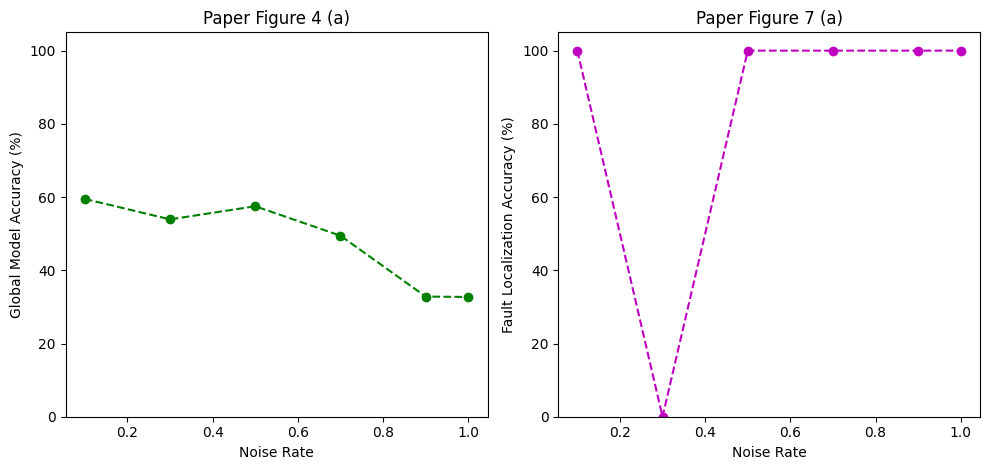

In [11]:
x =different_noise_levels 
y1_test_acc = [y[1] for y in nosie2results]
y2_fault_acc = [y[2] for y in nosie2results]
fig, axes = plt.subplots(1, 2) 
axes[0].plot(x, y1_test_acc, 'g--o') 
axes[1].plot(x, y2_fault_acc, 'm--o')

axes[0].set_xlabel('Noise Rate')
axes[1].set_xlabel('Noise Rate')
axes[0].set_ylabel('Global Model Accuracy (%)')
axes[1].set_ylabel('Fault Localization Accuracy (%)')
axes[0].set_title("Paper Figure 4 (a)")
axes[1].set_title("Paper Figure 7 (a)")

axes[0].set_ylim(0, 105)
axes[1].set_ylim(0, 105)

fig.set_figwidth(10)

plt.tight_layout()
